## 라이브러리

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


## albumentaions 정의

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

## 키티 데이터 전처리
- glob(): 파일이름에 규칙성이 있는 여러파일 한꺼번에 가져옴.
- assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    '''
    이미지,라벨을 가져와서 정렬하고 
    이미지와 라벨수가 같으면 data에 zip으 상요해 이미지와 라벨을 묶어서 저장
    개수가 다르면 assert 에러 반환
    '''
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train: # 학습데이터면 뒤에 30개 빼고
      return data[:-30]
    return data[-30:]# 테스트데이터면 뒤에 30개 반환
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

## albumentaion 적용후 키티 제너레이터를 이용해 학습 테스트 데이터 전처리 및  분리

In [4]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## IOU 계산

In [5]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

## 아웃풋 정의 
- prediction, target 도 같이 반환

In [6]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

## U-net pp 모델 빌딩

In [7]:
def unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    # x 0,0
    conv_00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv_00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_00)
    pool_00 = MaxPooling2D(pool_size=(2, 2))(conv_00) 

    # x 1,0
    conv_10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_00)
    conv_10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_10)
    pool_10 = MaxPooling2D(pool_size=(2, 2))(conv_10)
    
    # x 2,0
    conv_20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_10)
    conv_20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_20)
    pool_20 = MaxPooling2D(pool_size=(2, 2))(conv_20)
    
    # x 3,0
    conv_30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_20)
    conv_30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_30)
    pool_30 = MaxPooling2D(pool_size=(2, 2))(conv_30)
    
    # x 4,0
    conv_40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_30)
    conv_40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_40)
    
    # x 0,1
    up_01 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_10)
    merge_01 = concatenate([conv_00,up_01], axis = 3)
    conv_01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_01)
    conv_01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_01)
    
    # x 1,1
    up_11 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_20)
    merge_11 = concatenate([conv_10,up_11], axis = 3)
    conv_11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_11)
    conv_11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_11)
    
    # x 2,1
    up_21 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_30)
    merge_21 = concatenate([conv_20,up_21], axis = 3)
    conv_21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_21)
    conv_21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_21)
    
    # x 3,1
    up_31 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_40)
    merge_31 = concatenate([conv_30,up_31], axis = 3)
    conv_31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_31)
    conv_31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_31)
    
    # x 0,2
    up_02 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_11)
    merge_02 = concatenate([conv_01,up_02], axis = 3)
    conv_02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_02)
    conv_02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_02)
    
    # x 1,2
    up_12 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_21)
    merge_12 = concatenate([conv_11,up_12], axis = 3)
    conv_12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_12)
    conv_12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_12)
    
    # x 2,2
    up_22 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_31)
    merge_22 = concatenate([conv_21,up_22], axis = 3)
    conv_22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_22)
    conv_22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_22)
    
    # x 0,3
    up_03 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_12)
    merge_03 = concatenate([conv_02,up_03], axis = 3)
    conv_03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_03)
    conv_03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_03)
    
    # x 1,3
    up_13 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_22)
    merge_13 = concatenate([conv_12,up_13], axis = 3)
    conv_13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_13)
    conv_13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_13)
    
    # x 0,4
    up_04 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv_13)
    merge_04 = concatenate([conv_03,up_04], axis = 3)
    conv_04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_04)
    conv_04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_04)
    
    conv5 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv_04)     
    output = Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs = inputs, outputs = output)
    return model

model = unet_pp()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## U-net 모델 불러오기

In [8]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

unet = tf.keras.models.load_model(model_path)

## U-net pp모델 학습

In [9]:
#model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unetpp = unet_pp()
unetpp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unetpp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

#model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 27s 711ms/step - loss: 0.6850 - val_loss: 0.6665
Epoch 2/100
22/22 [==============================] - 15s 692ms/step - loss: 0.3540 - val_loss: 0.0615
Epoch 3/100
22/22 [==============================] - 15s 682ms/step - loss: 0.0747 - val_loss: 0.0559
Epoch 4/100
22/22 [==============================] - 15s 689ms/step - loss: 0.0622 - val_loss: 0.0591
Epoch 5/100
22/22 [==============================] - 15s 693ms/step - loss: 0.0467 - val_loss: 0.0445
Epoch 6/100
22/22 [==============================] - 15s 695ms/step - loss: 0.0463 - val_loss: 0.0479
Epoch 7/100
22/22 [==============================] - 15s 698ms/step - loss: 0.0386 - val_loss: 0.0384
Epoch 8/100
22/22 [==============================] - 15s 701ms/step - loss: 0.0383 - val_loss: 0.0393
Epoch 9/100
22/22 [==============================] - 15s 703ms/step - loss: 0.0379 - val_loss: 0.0452
Epoch 10/100
22/22 [==============================] - 16s 707ms/step - loss: 0.038

## U-net 결과 확인

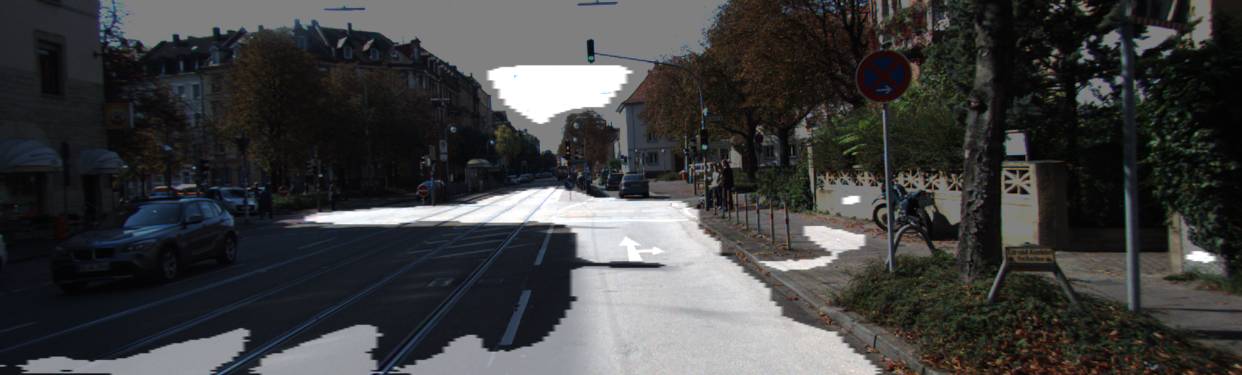

IoU : 0.419641


0.41964089410040306

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## U-net_pp 결과 확인

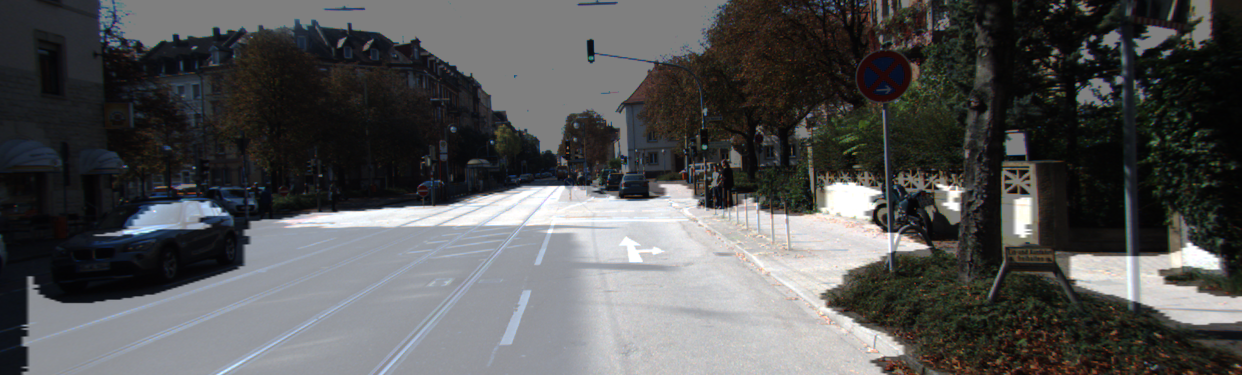

IoU : 0.764457


0.7644567100956293

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 회고
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? - yes
    - KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
    
2. U-Net++ 모델이 성공적으로 구현되었는가? - yes
    - U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
    
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? - yes
    - U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

- POOLING은 화살표, 그래서 UPSAMPLING과 MERGE시에 POOLING 레이어가 아니라 그전 출력값인 CONV레이어를 넣어 주어야 한다.